# Integration of the data sources and EDA

In [13]:
import requests
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import sys
sys.path.append('../src')

from data import world_bank as wb

In [2]:
END_DATE = 2017

cpi = wb.download_cpis(['uy', 'us'], end_date=END_DATE)
rate = wb.download_exchange_rate('uy', end_date=END_DATE)

In [3]:
print(cpi.shape)
print(rate.shape)

(58, 2)
(58, 1)


In [4]:
cpi.head()

,Uruguay,United States
1960,0.000004,13.563061
1961,0.000005,13.708284
1962,0.000005,13.872615
1963,0.000006,14.044590
1964,0.000009,14.224207


In [5]:
rate.head()

,Uruguay
1960,0.000011
1961,0.000011
1962,0.000011
1963,0.000015
1964,0.000016


In [6]:
data = cpi.join(rate.rename(columns={'Uruguay':'usd_uy'}))
data = data.rename(columns={'Uruguay': 'cpi_uy', 'United States': 'cpi_usa'})
print(data.shape)
data.head()

(58, 3)


,cpi_uy,cpi_usa,usd_uy
1960,0.000004,13.563061,0.000011
1961,0.000005,13.708284,0.000011
1962,0.000005,13.872615,0.000011
1963,0.000006,14.044590,0.000015
1964,0.000009,14.224207,0.000016


In [7]:
data['raw_q'] = data.cpi_uy / data.cpi_usa
data.head()

,cpi_uy,cpi_usa,usd_uy,raw_q
1960,0.000004,13.563061,0.000011,2.765001e-07
1961,0.000005,13.708284,0.000011,3.358009e-07
1962,0.000005,13.872615,0.000011,3.680164e-07
1963,0.000006,14.044590,0.000015,4.407730e-07
1964,0.000009,14.224207,0.000016,6.196018e-07


In [8]:
mean_coef = (data.usd_uy / data.raw_q).mean()
data['q_mean'] = mean_coef * data.raw_q

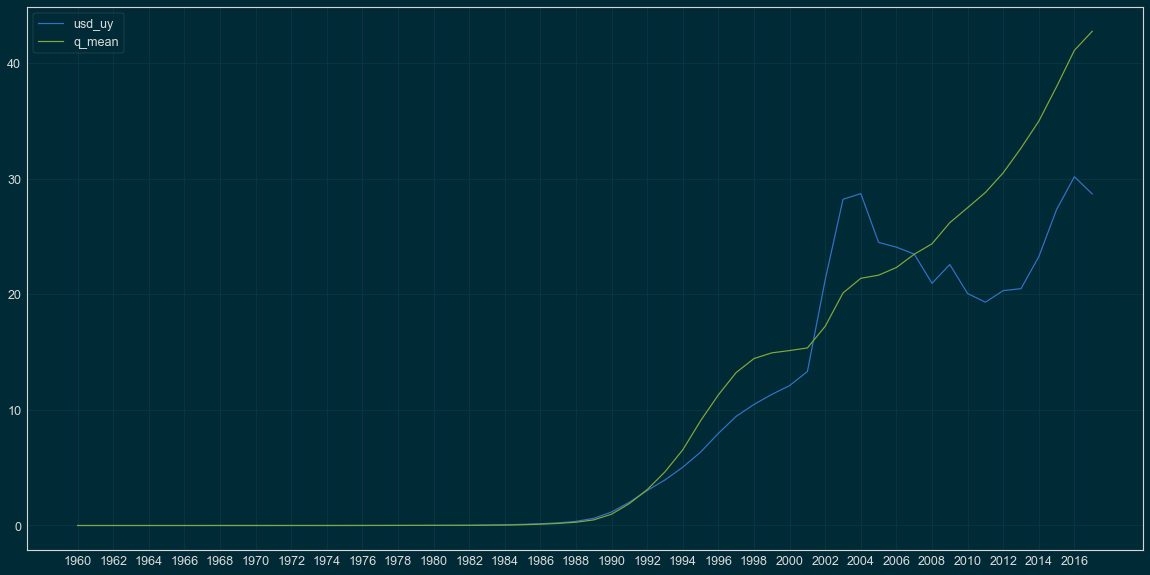

In [15]:
data[['usd_uy', 'q_mean']].plot(use_index=True)
_ = plt.xticks(np.arange(data.index.min(), data.index.max(), 2))

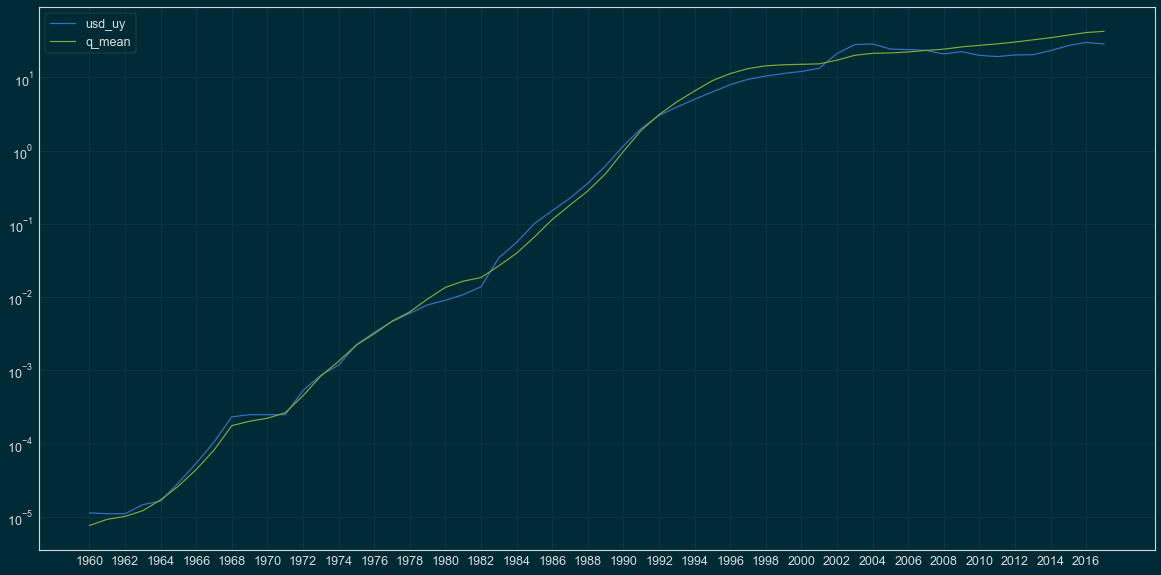

In [16]:
data[['usd_uy', 'q_mean']].plot(logy=True)
_ = plt.xticks(np.arange(data.index.min(), data.index.max(), 2))

That quotient is plotted just to see the effect, but it is not usable because it doesn't respect causality.

## Causal analysis

Let's first find if there is any significant difference by taking the mean of the quotients or performing least squares.

In [17]:
mean_coef

27.484474959655046

mean_coef = 27.484474959655046
a = 21.348139608108397, b = 0.5589049302476149


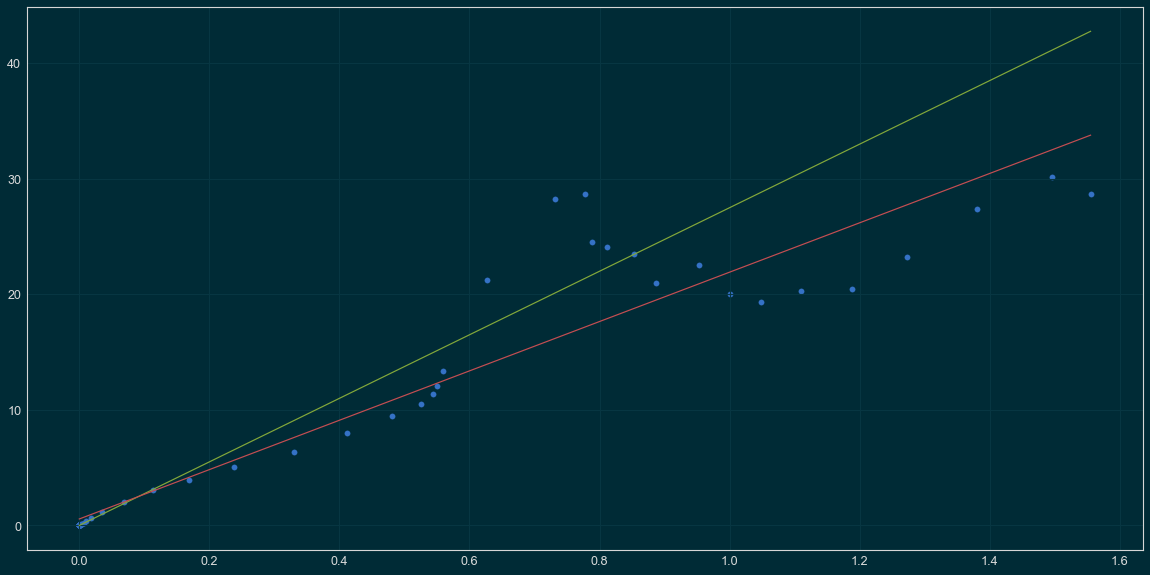

In [36]:
plt.scatter(data['raw_q'], data['usd_uy'])
xx = np.linspace(data['raw_q'].min(), data['raw_q'].max(), 100)
yy_mean = xx * mean_coef
plt.plot(xx, yy_mean, 'g')
p = np.polyfit(data['raw_q'], data['usd_uy'], 1)
yy_minsq = p[0] * xx + p[1]
plt.plot(xx, yy_minsq, 'r')
print('mean_coef = {}'.format(mean_coef))
print('a = {}, b = {}'.format(p[0], p[1]))

In [52]:
data[['raw_q', 'usd_uy']].head()

,raw_q,usd_uy
1960,2.765001e-07,0.000011
1961,3.358009e-07,0.000011
1962,3.680164e-07,0.000011
1963,4.407730e-07,0.000015
1964,6.196018e-07,0.000016


In [54]:
data['instant_mean_coef'] = data.usd_uy / data.raw_q
data['mean_coef'] = data.instant_mean_coef.expanding().mean()
data['causal_estimation'] = data.raw_q * data.mean_coef
data.head()

,cpi_uy,cpi_usa,usd_uy,raw_q,q_mean,instant_mean_coef,mean_coef,causal_estimation
1960,0.000004,13.563061,0.000011,2.765001e-07,0.000008,40.855916,40.855916,0.000011
1961,0.000005,13.708284,0.000011,3.358009e-07,0.000009,32.784808,36.820362,0.000012
1962,0.000005,13.872615,0.000011,3.680164e-07,0.000010,29.835627,34.492117,0.000013
1963,0.000006,14.044590,0.000015,4.407730e-07,0.000012,33.231388,34.176935,0.000015
1964,0.000009,14.224207,0.000016,6.196018e-07,0.000017,26.487440,32.639036,0.000020


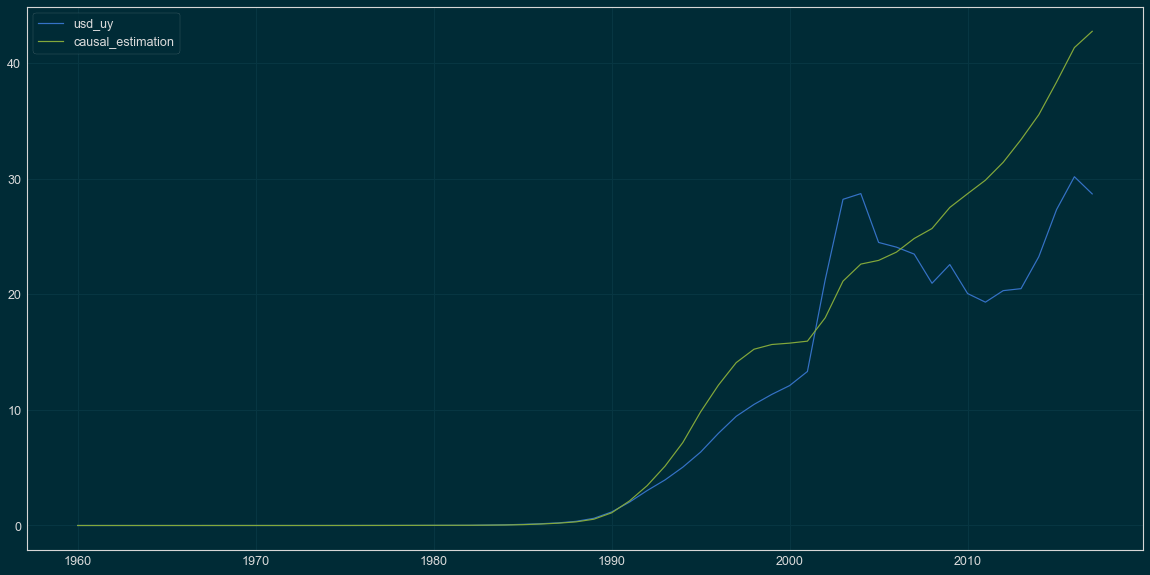

In [56]:
data[['usd_uy', 'causal_estimation']].plot()

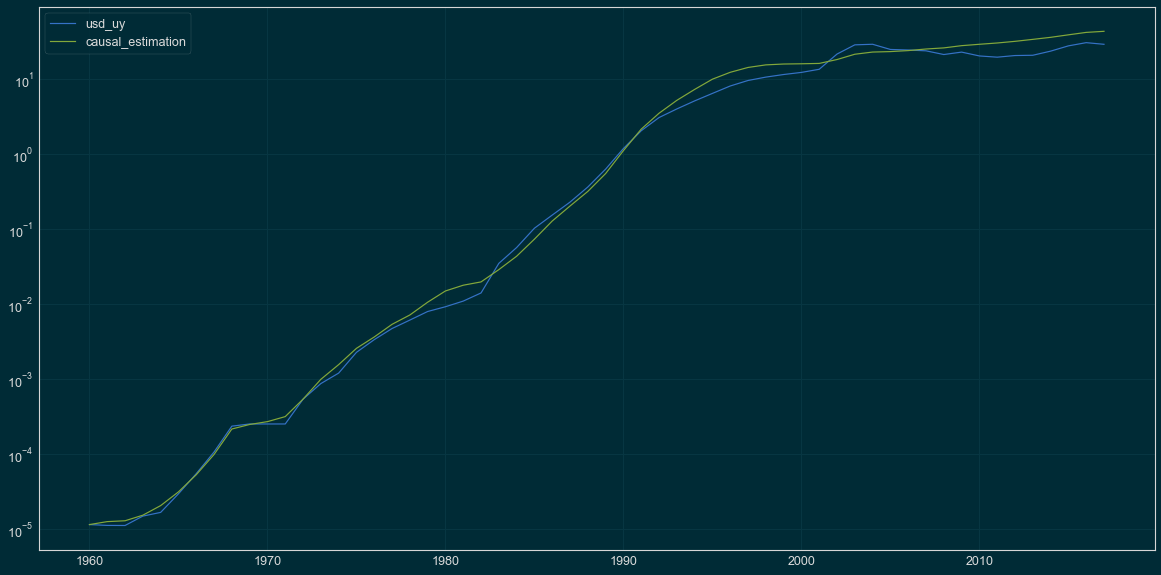

In [57]:
data[['usd_uy', 'causal_estimation']].plot(logy=True)

In [83]:
data['ewm_coef'] = data.instant_mean_coef.ewm(alpha=0.1).mean()
data['causal_estimation_ewm'] = data.raw_q * data.ewm_coef
data.head()

,cpi_uy,cpi_usa,usd_uy,raw_q,q_mean,instant_mean_coef,mean_coef,causal_estimation,ewm_coef,causal_estimation_ewm
1960,0.000004,13.563061,0.000011,2.765001e-07,0.000008,40.855916,40.855916,0.000011,40.855916,0.000011
1961,0.000005,13.708284,0.000011,3.358009e-07,0.000009,32.784808,36.820362,0.000012,36.607965,0.000012
1962,0.000005,13.872615,0.000011,3.680164e-07,0.000010,29.835627,34.492117,0.000013,34.108947,0.000013
1963,0.000006,14.044590,0.000015,4.407730e-07,0.000012,33.231388,34.176935,0.000015,33.853769,0.000015
1964,0.000009,14.224207,0.000016,6.196018e-07,0.000017,26.487440,32.639036,0.000020,32.054953,0.000020


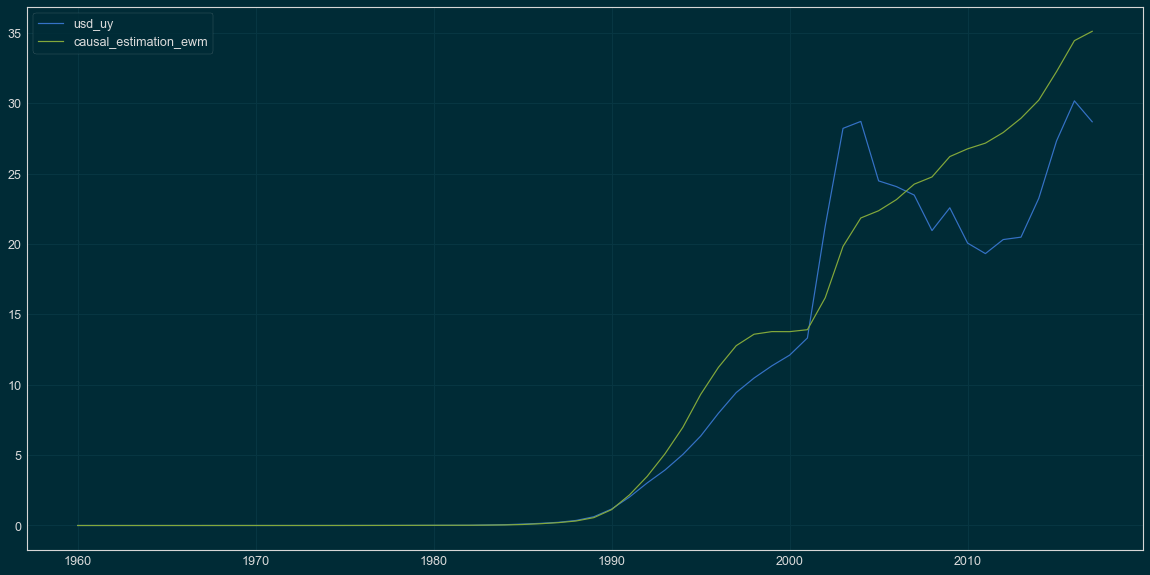

In [84]:
data[['usd_uy', 'causal_estimation_ewm']].plot()

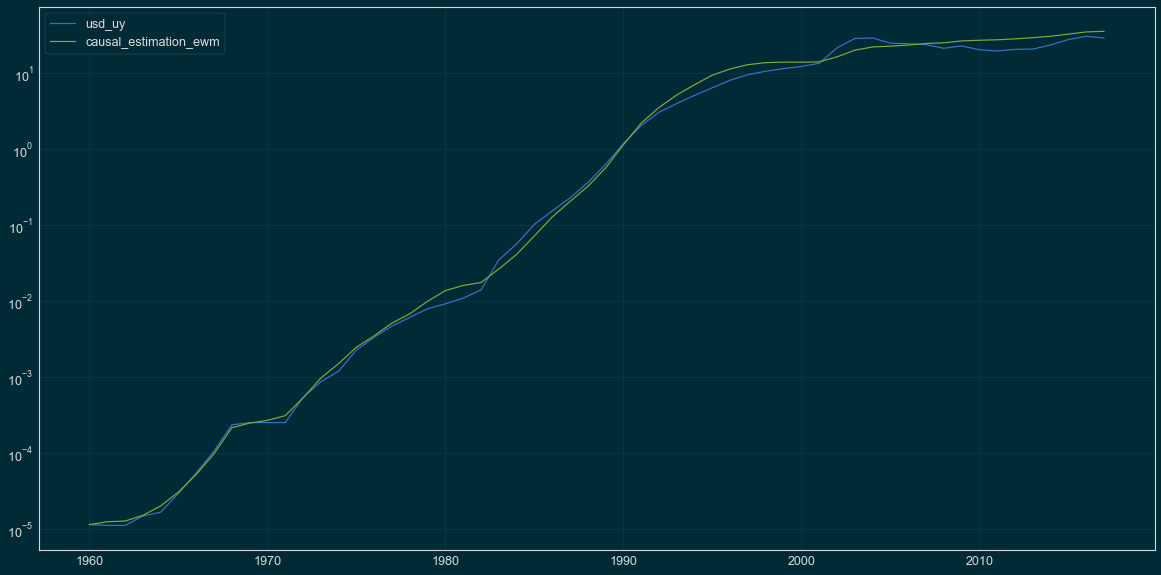

In [85]:
data[['usd_uy', 'causal_estimation_ewm']].plot(logy=True)

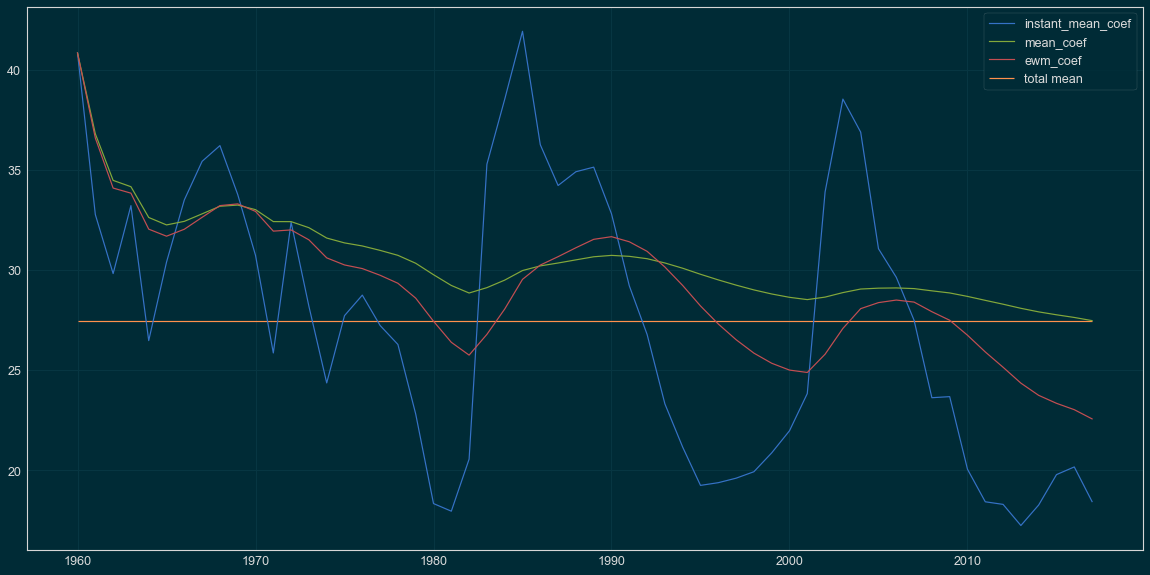

In [86]:
data[['instant_mean_coef', 'mean_coef', 'ewm_coef']].plot()
plt.hlines(mean_coef, data.index.min(), data.index.max(), 'y', label='total mean')
plt.legend()

I will use the expanding mean.

In [87]:
data['expanding_std_coef'] = data.instant_mean_coef.expanding().std()

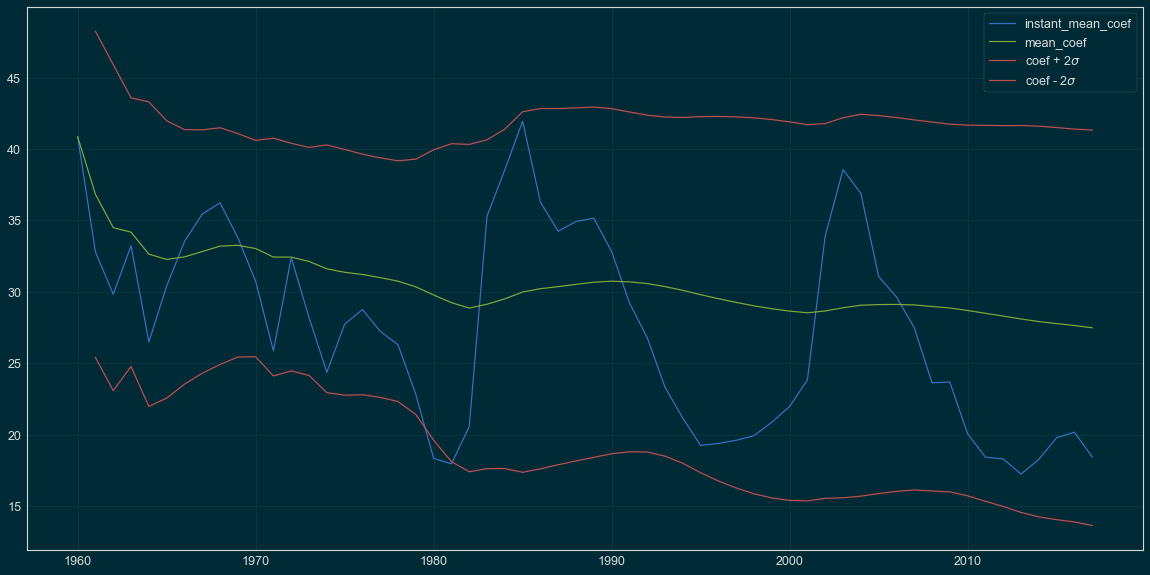

In [94]:
num_stds = 2
data[['instant_mean_coef', 'mean_coef']].plot()
plt.plot(data.index, data.mean_coef + num_stds * data.expanding_std_coef, 'r', 
         label='coef + {}$\sigma$'.format(num_stds))
plt.plot(data.index, data.mean_coef - num_stds * data.expanding_std_coef, 'r', 
         label='coef - {}$\sigma$'.format(num_stds))
plt.legend()

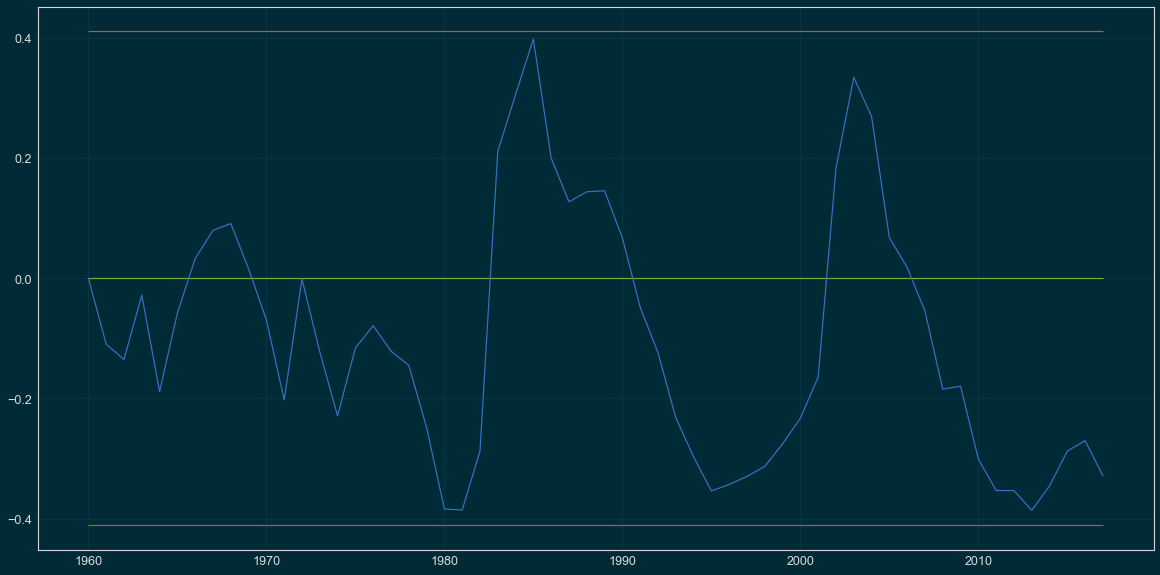

In [113]:
relative_e = (data.usd_uy - data.causal_estimation) / data.causal_estimation
relative_e.plot()
plt.hlines(0, data.index.min(), data.index.max(), 'g')
plt.hlines(2 * relative_e.std(), data.index.min(), data.index.max(), 'r')
plt.hlines(-2 * relative_e.std(), data.index.min(), data.index.max(), 'r')

Text(0.5,1,'Relative error')

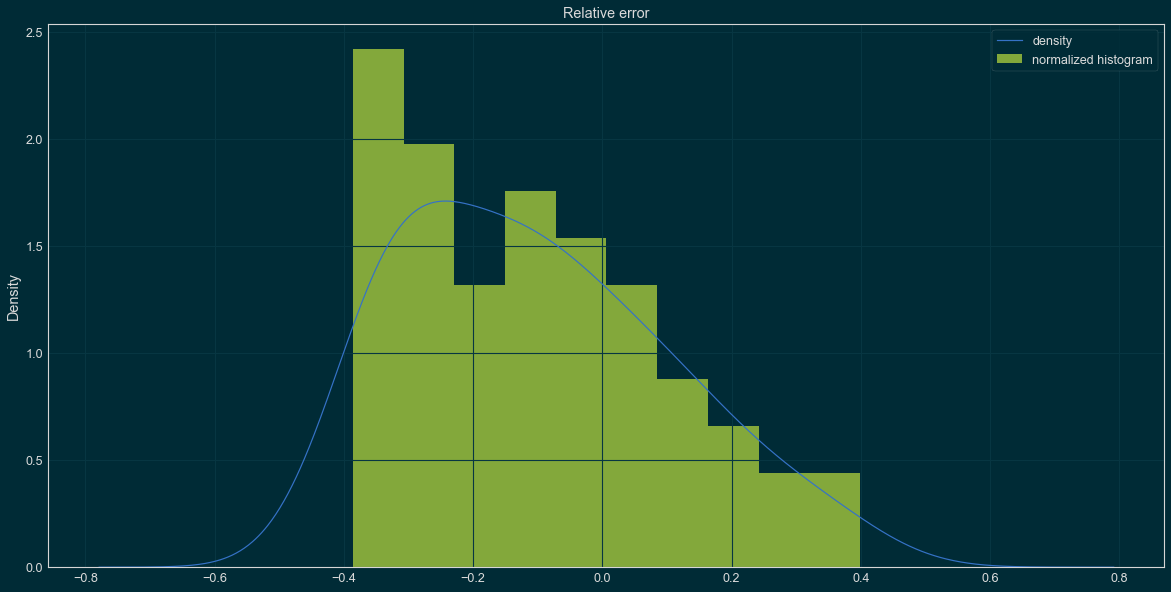

In [114]:
relative_e.plot(kind='density', label='density')
relative_e.hist(density=1, bins=10, label='normalized histogram')
plt.legend()
plt.title('Relative error')

In [116]:
data['max_causal_est'] = data.causal_estimation * (1 + 2 * relative_e.std())
data['min_causal_est'] = data.causal_estimation * (1 - 2 * relative_e.std())

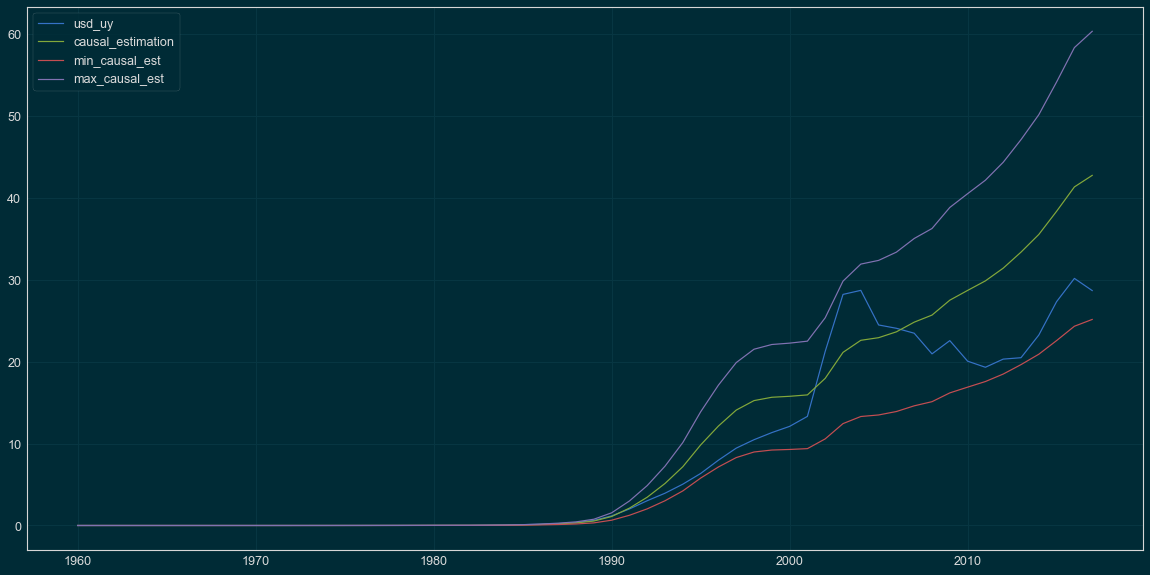

In [117]:
data[['usd_uy', 'causal_estimation', 'min_causal_est', 'max_causal_est']].plot()

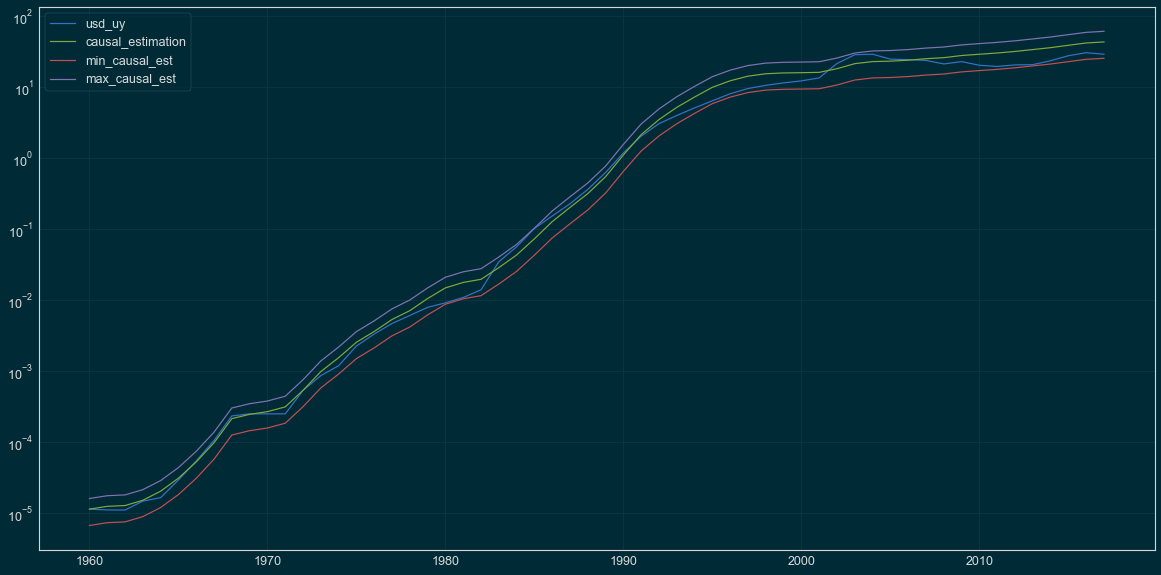

In [118]:
data[['usd_uy', 'causal_estimation', 'min_causal_est', 'max_causal_est']].plot(logy=True)